## sTXM - MISTRIAL

In [1]:
from IPython.display import display
import sys
from pathlib import Path as path
import numpy as np
import pandas as pd
import scipy

from dxchange import reader as reader
import hyperspy.api as hs

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap, to_rgba
import matplotlib.gridspec as gridspec
from matplotlib import ticker

In [2]:
# 画图的初始设置
plt.style.use(r'C:\Users\chengliu\OneDrive - UAB\ICMAB-python\Figure\liuchzzyy.mplstyle')
# display(plt.style.available)

# 颜色设定
sys.path.append(r'C:\Users\chengliu\OneDrive - UAB\ICMAB-Python\Figure')
from colors import tol_cmap, tol_cset
colors = list(tol_cset('vibrant'))
if r'sunset' not in plt.colormaps():
    plt.colormaps.register(tol_cmap('sunset'))
if r'rainbow_PuRd' not in plt.colormaps():
    plt.colormaps.register(tol_cmap('rainbow_PuRd'))  # 备用 plasma

# 输出的文件夹
path_out = path(r"C:\Users\chengliu\Desktop\Figure")

In [3]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
def add_sizebar(ax, size, data, color):
    asb = AnchoredSizeBar(ax.transData,
                          size / data.axes_manager["x_position"].scale,
                          '{} {}'.format(size, data.axes_manager['x_position'].units),
                          loc='lower left',
                          pad=0.1, borderpad=0.5, sep=0.5,
                          frameon=False,
                          color=color,
                         label_top=True)
    sizebar = ax.add_artist(asb)
    return sizebar

def transparent_single_color_cmap(color):
    """Return a single color matplotlib cmap with the transparency increasing
    linearly from 0 to 1."""
    return LinearSegmentedColormap.from_list("", [to_rgba(color, 0), to_rgba(color, 1)])

### 读取原始数据

In [4]:
path_folder = path(r'C:\Users\chengliu\OneDrive - UAB\ICMAB-Data\Zn-Mn\Uno\Result\sTXM\ExSitu\αMnO2\Charge\1st1.53V\2023-MIXSTRAL\F2 1st1.53V')
path_file = path.joinpath(path_folder, r'Data', r'20230630_F2Zn_855.7x741.1y_specnorm.hdf5')

# Read the keys to find dataset, data_key is a list shown as below
data_key = reader.read_hdf_meta(path_file, add_shape=True)
display(data_key)

# Read all needed dataset via keys
data_unalignment = reader.read_hdf5(path_file, dataset=r'SpecNormalized/spectroscopy_normalized', shared=False)
energy = reader.read_hdf5(path_file, dataset=r'SpecNormalized/energy', shared=False)
data_x_pixel_size = reader.read_hdf5(path_file, dataset=r'SpecNormalized/x_pixel_size', shared=False)
data_y_pixel_size = reader.read_hdf5(path_file, dataset=r'SpecNormalized/y_pixel_size', shared=False)

(deque([' SpecNormalized',
        '    │',
        '    ├── Currents (107,)',
        '    ├── ExpTimes (107,)',
        '    ├── energy (107,)',
        '    ├── rotation_angle (107,)',
        '    ├── spectroscopy_normalized (107, 972, 982)',
        '    ├── x_pixel_size (1,)',
        '    └── y_pixel_size (1,)']),
 {'SpecNormalized_x_pixel_size': [0.013000000268220901, None],
  'SpecNormalized_y_pixel_size': [0.013000000268220901, None]})

In [5]:
# Bulid hyperspy object: a 2D image stack signal, and then plot it
from hyperspy.axes import DataAxis, UniformDataAxis
energy_axis = DataAxis(axis=energy, index_in_array=None, name='Energy', units='eV',)
x_position = UniformDataAxis(offset=0,scale=data_x_pixel_size[0],size=data_unalignment.shape[2], name=r'x_position', units=r'um')
y_position = UniformDataAxis(offset=0,scale=data_y_pixel_size[0],size=data_unalignment.shape[1], name=r'y_position', units=r'um')
data_2d = hs.signals.Signal2D(data_unalignment, axes=[energy_axis, x_position, y_position])

#### 对 Energy Axis 进行插值修改

In [6]:
hs.set_log_level('ERROR')
from hyperspy.axes import UniformDataAxis
new_scale = 0.1
axis_new = UniformDataAxis(offset=energy[0], scale=new_scale, size=((energy.max() - energy.min())//new_scale+1), name="Energy", units='eV', navigate=True, is_binned=True)
data_2d.interpolate_on_axis(axis_new, 0, inplace=True)
data_2d.axes_manager

Navigation axis name,size,index,offset,scale,units
Energy,398,0,1010.011962890625,0.1,eV
Signal axis name,size,,offset,scale,units
y_position,972,,0.0,0.013000000268220901,um
x_position,982,,0.0,0.013000000268220901,um


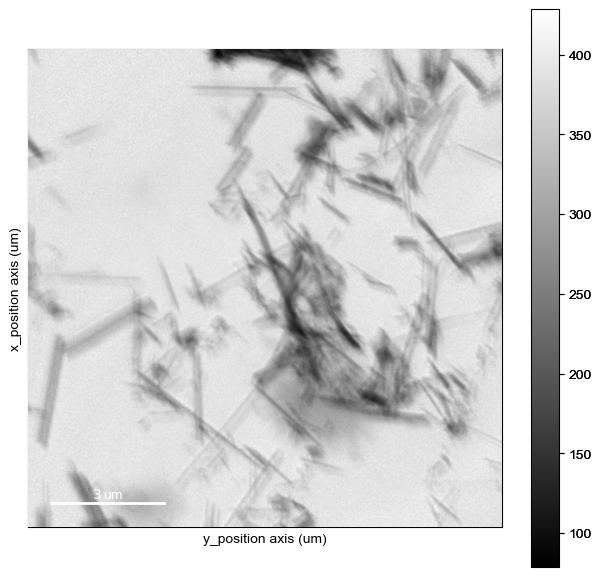

In [7]:
# check the ambiguous image stack
%matplotlib inline
data_2d.transpose(signal_axes=(0,), optimize=True).integrate1D(axis=-1).plot()

#### 数据对齐

In [8]:
shifts = data_2d.estimate_shift2D()
data_2d.align2D(shifts=shifts, show_progressbar=True,)

  0%|          | 0/398 [00:00<?, ?it/s]

[########################################] | 100% Completed | 698.79 ms


In [9]:
# convert Transimission to Absorbance
%matplotlib widget
s = data_2d.transpose(signal_axes=(0,), optimize=True).deepcopy()
s = -np.log(s)
s.plot()

In [10]:
# # crop the region saturation
# s.crop(axis=1, start=0.0, end=8.7)

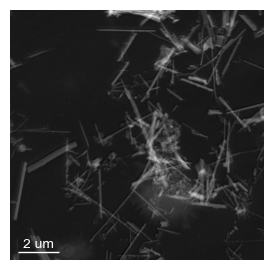

In [11]:
# Th figure after alignment
%matplotlib inline
plt.close('all')
fig = plt.figure(figsize=(3.3, 2.5))
gs = gridspec.GridSpec(1, 1, width_ratios=None, height_ratios=None, wspace=0, hspace=0, figure=fig)

# 图 
subfig = fig.add_subfigure(gs[0, 0], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0, 0, 1, 1])
ax.imshow(s.integrate1D(axis=-1).data, cmap='gray')
add_sizebar(ax, 2, s.integrate1D(axis=-1), 'white')
ax.set_axis_off()
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False,)

plt.savefig(path.joinpath(path_out, r'1_300_sTXM_HADDF.tif'), pad_inches=0.0, bbox_inches='tight', dpi=300, transparent=False, pil_kwargs={"compression": "tiff_lzw"})
plt.savefig(path.joinpath(path_out, r'1_600_sTXM_HADDF.tif'), pad_inches=0.0, bbox_inches='tight', dpi=600, transparent=False, pil_kwargs={"compression": "tiff_lzw"})
plt.show()

In [12]:
%%time
s.save(path.joinpath(path_out, r'1_data_aligned.hspy'), overwrite=True)

CPU times: total: 57.3 s
Wall time: 57.9 s


### PCA 降噪

In [13]:
%%time
# PCA 
s.decomposition(algorithm="SVD",  navigation_mask=None, reproject='signal',)   # centre="navigation"  centre="signal"
# ps.plot_explained_variance_ratio(n=20, threshold=3, vline=True)
num_components = s.estimate_elbow_position()  # component number =  num_components + 1 
# display(num_components)
# s.plot_decomposition_results()
# s.plot_decomposition_loadings(comp_ids=num_components+1, axes_decor="off", with_factors=True, per_row=(num_components+1)//2,)
# reconstruct data
ps_recon = s.get_decomposition_model(components=3*(num_components+1))

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=None
  centre=None
CPU times: total: 28min 26s
Wall time: 1min 32s


In [14]:
%matplotlib ipympl
ps_recon.plot()

### 过滤空白像素

In [15]:
mask_empty_vaule = [0.04, 0.5, 0.99]
ps_recon_sum = ps_recon.integrate1D(axis='Energy')
ps_recon_sum = ps_recon_sum/ps_recon_sum.nanmax().data[0]
mask_empty = (ps_recon_sum < mask_empty_vaule[0]) | (ps_recon_sum > mask_empty_vaule[2])
mask_empty.save(path.joinpath(path_out, r'2_mask_empty.hspy'), overwrite=True)

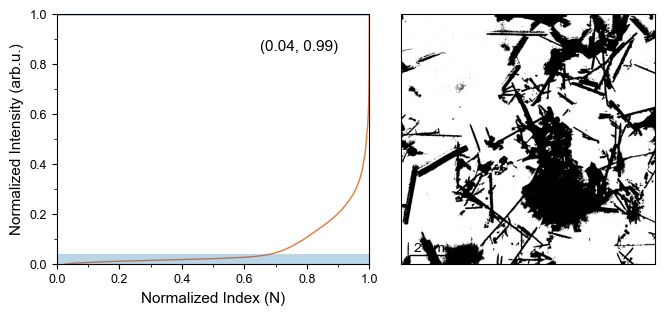

In [16]:
# Empty filter 
%matplotlib inline 
plt.close('all')
fig = plt.figure(figsize=(7, 2.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], height_ratios=None, wspace=0, hspace=0, figure=fig)

# 图 A
subfig = fig.add_subfigure(gs[0, 0], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0, 0, 1.0, 1.0])
ax.set_box_aspect(0.8)

ax.plot(np.linspace(0, 1, ps_recon_sum.data.flatten().shape[0], endpoint=True), np.sort(ps_recon_sum.data.flatten()), color=colors[0]) 

ax.set_ylabel(r'Normalized Intensity (arb.u.)', fontsize=11,)
ax.set_ylim(0.0, 1.0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.2, offset=0))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.1, offset=0))

ax.set_xlabel(r'Normalized Index (N)', fontsize=11,)
ax.set_xlim(0.0, 1.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.2, offset=0))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.1, offset=0))

ax.axhspan(ymin=0.0, ymax=mask_empty_vaule[0], alpha=0.3, zorder=2)
ax.axhspan(ymin=mask_empty_vaule[2], ymax=1.0, alpha=0.3, zorder=2)

# ax.legend(loc='upper left', bbox_to_anchor=(0.6, 1.0), ncols=1, frameon=False, fontsize=12, labelcolor='linecolor', columnspacing=0.4)
ax.text(0.65, 0.9, f'{mask_empty_vaule[0], mask_empty_vaule[2]}', horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=11, c='k')
ax.tick_params(axis='both', which='both', labelsize=9, bottom=True, left=True, top=False, right=False, labelbottom=True, labelleft=True, labeltop=False, labelright=False)

# 图 B
subfigb = fig.add_subfigure(gs[0, 1], zorder=0)
ax = subfigb.add_subplot()
ax.set_position([-0.1, 0.0, 1.0, 1.0])
ax.imshow(mask_empty.data, cmap='gray', aspect=1.0)
add_sizebar(ax, 2, mask_empty, 'k')
ax.tick_params(axis='both', which='both', labelsize=9, bottom=False, left=False, top=False, right=False, labelbottom=False, labelleft=False, labeltop=False, labelright=False)

plt.savefig(path.joinpath(path_out, r'2_300_sTXM_mask_empty.tif'), pad_inches=0.0, bbox_inches='tight', dpi=300, transparent=False, pil_kwargs={"compression": "tiff_lzw"})
plt.savefig(path.joinpath(path_out, r'2_600_sTXM_mask_empty.tif'), pad_inches=0.0, bbox_inches='tight', dpi=600, transparent=False, pil_kwargs={"compression": "tiff_lzw"})
plt.show()

#### 确定中间值

In [17]:
def Bvalue(x, B, C):
    return -np.log((np.exp(-x*C)+B)/(1+B))
def linear_model(x, m, b):
    return m * x + b
def calculate_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)  # 残差平方和
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  # 总体平方和
    return 1 - (ss_res / ss_tot)

In [18]:
from tqdm.notebook import tqdm
sol = []
for k in tqdm(np.linspace(mask_empty_vaule[0]+0.01, mask_empty_vaule[2], 100, endpoint=False)):
    try:
        mask_vaule = [mask_empty_vaule[0], k,  mask_empty_vaule[2]]
        mask_thin = (ps_recon_sum >= mask_vaule[0]) & (ps_recon_sum <= mask_vaule[1])
        mask_thick = (ps_recon_sum > mask_vaule[1]) & (ps_recon_sum < mask_vaule[2])

        thick_1d = np.sort(np.nanmean(ps_recon.data[mask_thick.data], axis=0))
        thin_1d = np.sort(np.nanmean(ps_recon.data[mask_thin.data], axis=0))
        popt_mapping, pcov_mapping = scipy.optimize.curve_fit(Bvalue, xdata=thin_1d, ydata=thick_1d, method='trf', bounds=([0, -np.inf], [1, np.inf]))

        ps_recon_mapping = ps_recon.deepcopy()
        ps_recon_mapping.data = -np.log((1+popt_mapping[0])*np.exp(-ps_recon_mapping.data) - popt_mapping[0])
        mask_nan_mapping = np.isnan(ps_recon_mapping.mean(-1))    
        thick_1d_b = np.sort(np.nanmean(ps_recon_mapping.data[mask_thick.data], axis=0))
        thin_1d_b = np.sort(np.nanmean(ps_recon_mapping.data[mask_thin.data], axis=0))
        
        popt_linear_mapping, pcov_linear_mapping = scipy.optimize.curve_fit(linear_model, xdata=thin_1d_b, ydata=thick_1d_b, method='lm')
        r2 = calculate_r2(thick_1d_b, linear_model(thin_1d_b, *popt_linear_mapping))
        sol.append([k, popt_mapping, popt_linear_mapping, r2])
    except Exception as e:
        print(f"Error processing value {k}: {e}")
        continue   # 忽略错误继续循环

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\chengliu\AppData\Local\Temp\ipykernel_33228\1458461465.py:14: RuntimeWarning: invalid value encountered in log
  ps_recon_mapping.data = -np.log((1+popt_mapping[0])*np.exp(-ps_recon_mapping.data) - popt_mapping[0])


In [19]:
sol =  pd.DataFrame(sol)
print(sol.iloc[sol.iloc[:, 3].idxmax(), 0], sol.iloc[sol.iloc[:, 3].idxmax(), 1], sol.iloc[sol.iloc[:, 3].idxmax(), 2], sol.iloc[sol.iloc[:, 3].idxmax(), 3])
sol.to_csv(path.joinpath(path_out, r'2_Vaule_thin_thinck.csv'), sep=',', header=[r'k', r'popt_abs', r'popt_linear_abs', r'r2'])

0.9805999999999999 [0.02267309 6.01321546] [5.82439916e+00 4.84669738e-03] 0.9911015292110033


#### 最后的结果

In [20]:
mask_vaule = [mask_empty_vaule[0], sol.iloc[sol.iloc[:, 3].idxmax(), 0], mask_empty_vaule[2]]
mask_empty = (ps_recon_sum < mask_vaule[0]) | (ps_recon_sum > mask_vaule[2])
mask_thin = (ps_recon_sum >= mask_vaule[0]) & (ps_recon_sum <= mask_vaule[1])
mask_thick = (ps_recon_sum > mask_vaule[1]) & (ps_recon_sum < mask_vaule[2])

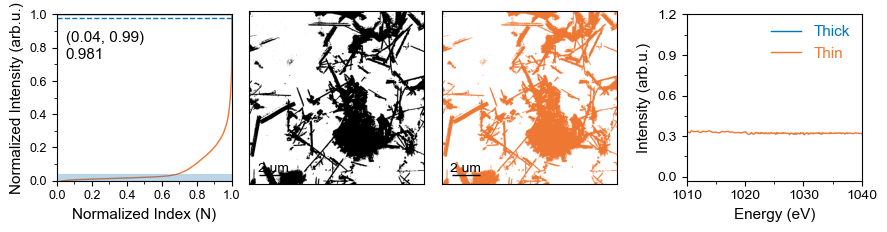

In [21]:
# Empty filter 
%matplotlib inline 
plt.close('all')
fig = plt.figure(figsize=(7, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1], height_ratios=None, wspace=0, hspace=0, figure=fig)

# 图 A
subfig = fig.add_subfigure(gs[0, 0], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0, 0, 1.0, 1.0])
ax.set_box_aspect(0.95)

ax.plot(np.linspace(0, 1, ps_recon_sum.data.flatten().shape[0], endpoint=True), np.sort(ps_recon_sum.data.flatten()), color=colors[0]) 

ax.set_ylabel(r'Normalized Intensity (arb.u.)', fontsize=11,)
ax.set_ylim(0.0, 1.0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.2, offset=0))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.1, offset=0))

ax.set_xlabel(r'Normalized Index (N)', fontsize=11,)
ax.set_xlim(0.0, 1.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.2, offset=0))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.1, offset=0))

ax.axhspan(ymin=0.0, ymax=mask_vaule[0], alpha=0.3, zorder=2)
ax.axhspan(ymin=mask_vaule[2], ymax=1.0, alpha=0.3, zorder=2)
ax.axhline(y=mask_vaule[1], alpha=1.0, ls='--', c=colors[1], zorder=2)

# ax.legend(loc='upper left', bbox_to_anchor=(0.6, 1.0), ncols=1, frameon=False, fontsize=12, labelcolor='linecolor', columnspacing=0.4)
ax.text(0.05, 0.9, f'{mask_vaule[0], mask_vaule[2]}', horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=11, c='k')
ax.text(0.05, 0.8, f'{mask_vaule[1]:.3f}', horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=11, c='k')
ax.tick_params(axis='both', which='both', labelsize=9, bottom=True, left=True, top=False, right=False, labelbottom=True, labelleft=True, labeltop=False, labelright=False)

# 图 B
subfigb = fig.add_subfigure(gs[0, 1], zorder=0)
ax = subfigb.add_subplot()
ax.set_position([0.1, 0.0, 1.0, 1.0])
ax.imshow(mask_empty.data, cmap='gray', aspect=1.0)
add_sizebar(ax, 2, mask_empty, 'k')
ax.tick_params(axis='both', which='both', labelsize=9, bottom=False, left=False, top=False, right=False, labelbottom=False, labelleft=False, labeltop=False, labelright=False)

# 图 C
subfigb = fig.add_subfigure(gs[0, 2], zorder=0)
ax = subfigb.add_subplot()
ax.set_position([0.2, 0.0, 1.0, 1.0])
ax.imshow(mask_thin.data, cmap=transparent_single_color_cmap(colors[0]), aspect=1.0)
ax.imshow(mask_thick.data, cmap=transparent_single_color_cmap(colors[1]), aspect=1.0, alpha=1.0)
add_sizebar(ax, 2, mask_thin, 'k')
ax.tick_params(axis='both', which='both', labelsize=9, bottom=False, left=False, top=False, right=False, labelbottom=False, labelleft=False, labeltop=False, labelright=False)

# 图 D
subfig = fig.add_subfigure(gs[0, 3], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0.6, 0.0, 1.0, 1.0])
ax.set_box_aspect(0.95)

thick_1d = np.nanmean(ps_recon.data[mask_thick.data], axis=0)
thin_1d = np.nanmean(ps_recon.data[mask_thin.data], axis=0)
ax.plot(ps_recon.axes_manager['Energy'].axis, thick_1d, color=colors[1], label=r'Thick')
ax.plot(ps_recon.axes_manager['Energy'].axis, thin_1d, color=colors[0], label=r'Thin')

ax.set_xlim(1010.0, 1040.0)
ax.set_ylim(-0.03, 1.2)
ax.set_xlabel(r'Energy (eV)', fontsize=11,)
ax.set_ylabel(r'Intensity (arb.u.)', fontsize=11, labelpad=5,)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.3, offset=0))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.15, offset=0))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10, offset=0))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=5, offset=0))
ax.legend(loc='upper left', bbox_to_anchor=(0.4, 1.02), ncols=1, frameon=False, fontsize=11, labelcolor='linecolor', columnspacing=0.4)

plt.savefig(path.joinpath(path_out, r'2_300_sTXM_mask_thin_thick.tif'), pad_inches=0.0, bbox_inches='tight', dpi=300, transparent=False, pil_kwargs={"compression": "tiff_lzw"})
plt.savefig(path.joinpath(path_out, r'2_600_sTXM_mask_thin_thick.tif'), pad_inches=0.0, bbox_inches='tight', dpi=600, transparent=False, pil_kwargs={"compression": "tiff_lzw"})
plt.show()

#### B vaule remove

In [22]:
def Bvalue(x, B, C):
    return -np.log((np.exp(-x*C)+B)/(1+B))

In [23]:
thick_1d = np.sort(np.nanmean(ps_recon.data[mask_thick.data], axis=0))
thin_1d = np.sort(np.nanmean(ps_recon.data[mask_thin.data], axis=0))
popt_mapping, pcov_mapping = scipy.optimize.curve_fit(Bvalue, xdata=thin_1d, ydata=thick_1d, method='trf', bounds=([0, -np.inf], [1, np.inf]))
popt_mapping

array([0.02267309, 6.01321546])

In [24]:
ps_recon_mapping = ps_recon.deepcopy()
ps_recon_mapping.data = -np.log((1+popt_mapping[0])*np.exp(-ps_recon.data) - popt_mapping[0])
mask_nan = np.isnan(ps_recon_mapping.mean(-1))

In [25]:
mask_empty = mask_empty | mask_nan
thick_1d_b = np.sort(np.nanmean(ps_recon_mapping.data[mask_thick.data], axis=0))
thin_1d_b = np.sort(np.nanmean(ps_recon_mapping.data[mask_thin.data], axis=0))

In [26]:
mask_empty.save(path.joinpath(path_out, r'2_mask_empty.hspy'), overwrite=True)

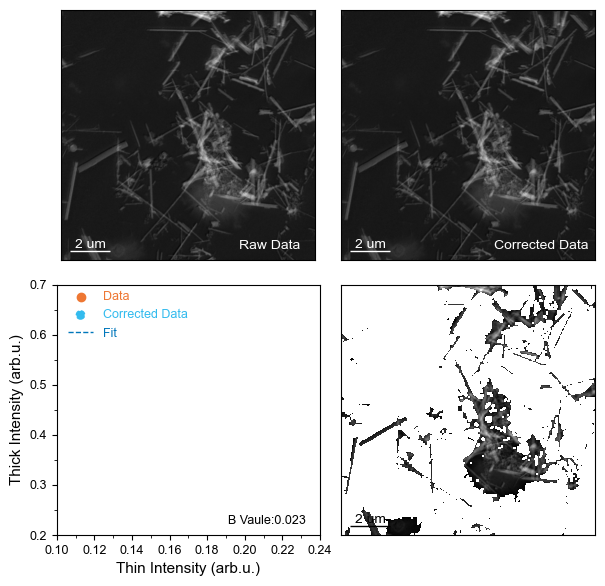

In [27]:
%matplotlib inline
plt.close('all')
fig = plt.figure(figsize=(7, 5))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], wspace=0, hspace=0, figure=fig)

# 图 A
subfig = fig.add_subfigure(gs[0, 0])
ax = subfig.add_subplot()
ax.set_position([0, 0, 1.0, 1.0])  
ax.imshow(ps_recon.mean(-1).data, cmap='gray')
add_sizebar(ax, 2, ps_recon.mean(-1), 'w')
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False,)
ax.text(0.7, 0.08, r'Raw Data', horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=10, c='w',)

# 图 B
subfig = fig.add_subfigure(gs[0, 1])
ax = subfig.add_subplot()
ax.set_position([-0.2, 0.0, 1.0, 1.0])  
ax.imshow(ps_recon_mapping.mean(-1).data, cmap='gray')
add_sizebar(ax, 2, ps_recon_mapping.mean(-1), 'w')
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False,)
ax.text(0.6, 0.08, r'Corrected Data', horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=10, c='w',)

# 图 C
subfig = fig.add_subfigure(gs[1, 0], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0, -0.1, 1.0, 1.0])
ax.set_box_aspect(0.95)
ax.scatter(x=thin_1d, y=thick_1d, label='Data', c=colors[0],)
ax.scatter(x=thin_1d_b, y=thick_1d_b, ls='--', c=colors[2], lw=1.0, label='Corrected Data')
ax.plot(thin_1d, Bvalue(thin_1d, *popt_mapping), ls='--', c=colors[1], lw=1.0, label='Fit')

ax.set_xlabel(r'Thin Intensity (arb.u.)', fontsize=11,)
ax.set_ylabel(r'Thick Intensity (arb.u.)', fontsize=11,)
ax.set_xlim(0.10, 0.24)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.02, offset=0))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.01, offset=0))
ax.set_ylim(0.2, 0.7)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1, offset=0))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.05, offset=0))
ax.text(0.65, 0.08, f'B Vaule:{popt_mapping[0]:0.3f}', horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=9, c='black', )
ax.tick_params(axis='both', labelsize=9) 
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.02), ncols=1, frameon=False, fontsize=9, labelcolor='linecolor', columnspacing=0.4)

# 图 D
subfig = fig.add_subfigure(gs[1, 1], zorder=0)
ax = subfig.add_subplot()
ax.set_position([-0.2, -0.1, 1.0, 1.0])
ps_recon_a = np.where(mask_empty, np.nan, ps_recon_mapping.mean('Energy'))
ax.imshow(ps_recon_a, cmap='gray')
add_sizebar(ax, 2, ps_recon_mapping, 'k')
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False,)

plt.savefig(path.joinpath(path_out, r'2_300_sTXM_mask_BValue.tif'), pad_inches=0.0, bbox_inches='tight', dpi=300, transparent=False, pil_kwargs={"compression": "tiff_lzw"})
plt.savefig(path.joinpath(path_out, r'2_600_sTXM_mask_BValue.tif'), pad_inches=0.0, bbox_inches='tight', dpi=600, transparent=False, pil_kwargs={"compression": "tiff_lzw"})
plt.show()

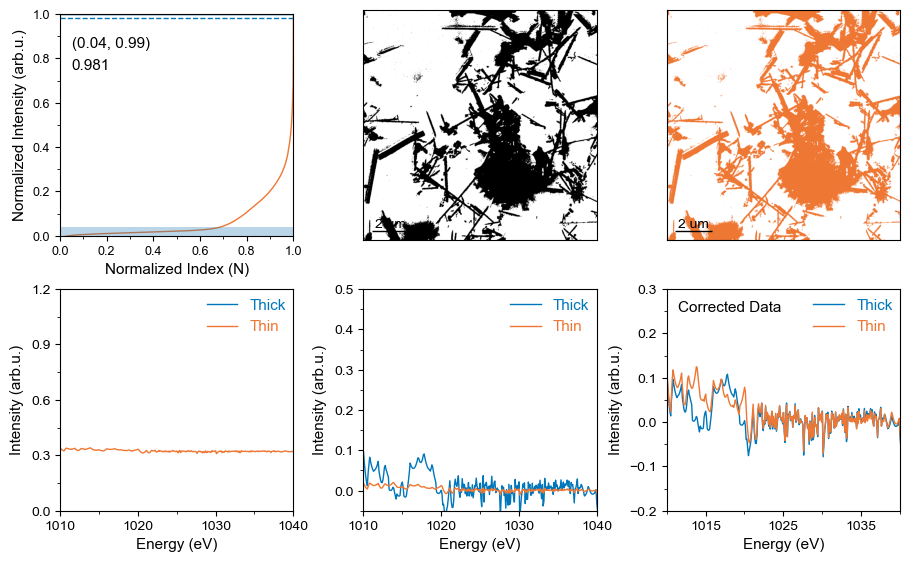

In [28]:
%matplotlib inline 
plt.close('all')
fig = plt.figure(figsize=(7, 5))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1,1], wspace=0, hspace=0, figure=fig)

# 图 A
subfig = fig.add_subfigure(gs[0, 0], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0, 0, 1.0, 1.0])
ax.set_box_aspect(0.95)

ax.plot(np.linspace(0, 1, ps_recon_sum.data.flatten().shape[0], endpoint=True), np.sort(ps_recon_sum.data.flatten()), color=colors[0]) 

ax.set_ylabel(r'Normalized Intensity (arb.u.)', fontsize=11,)
ax.set_ylim(0.0, 1.0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.2, offset=0))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.1, offset=0))

ax.set_xlabel(r'Normalized Index (N)', fontsize=11,)
ax.set_xlim(0.0, 1.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.2, offset=0))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.1, offset=0))

ax.axhspan(ymin=0.0, ymax=mask_vaule[0], alpha=0.3, zorder=2)
ax.axhspan(ymin=mask_vaule[2], ymax=1.0, alpha=0.3, zorder=2)
ax.axhline(y=mask_vaule[1], alpha=1.0, ls='--', c=colors[1], zorder=2)

# ax.legend(loc='upper left', bbox_to_anchor=(0.6, 1.0), ncols=1, frameon=False, fontsize=12, labelcolor='linecolor', columnspacing=0.4)
ax.text(0.05, 0.9, f'{mask_vaule[0], mask_vaule[2]}', horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=11, c='k')
ax.text(0.05, 0.8, f'{mask_vaule[1]:.3f}', horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=11, c='k')
ax.tick_params(axis='both', which='both', labelsize=9, bottom=True, left=True, top=False, right=False, labelbottom=True, labelleft=True, labeltop=False, labelright=False)

# 图 B
subfigb = fig.add_subfigure(gs[0, 1], zorder=0)
ax = subfigb.add_subplot()
ax.set_position([0.3, 0.0, 1.0, 1.0])
ax.imshow(mask_empty.data, cmap='gray', aspect=1.0)
add_sizebar(ax, 2, mask_empty, 'k')
ax.tick_params(axis='both', which='both', labelsize=9, bottom=False, left=False, top=False, right=False, labelbottom=False, labelleft=False, labeltop=False, labelright=False)

# 图 C
subfigb = fig.add_subfigure(gs[0, 2], zorder=0)
ax = subfigb.add_subplot()
ax.set_position([0.6, 0.0, 1.0, 1.0])
ax.imshow(mask_thin.data, cmap=transparent_single_color_cmap(colors[0]), aspect=1.0)
ax.imshow(mask_thick.data, cmap=transparent_single_color_cmap(colors[1]), aspect=1.0, alpha=1.0)
add_sizebar(ax, 2, mask_thin, 'k')
ax.tick_params(axis='both', which='both', labelsize=9, bottom=False, left=False, top=False, right=False, labelbottom=False, labelleft=False, labeltop=False, labelright=False)

# 图 D
subfig = fig.add_subfigure(gs[1, 0], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0, -0.1, 1.0, 1.0])
ax.set_box_aspect(0.95)

thick_1d = np.nanmean(ps_recon.data[mask_thick.data], axis=0)
thin_1d = np.nanmean(ps_recon.data[mask_thin.data], axis=0)
ax.plot(ps_recon.axes_manager['Energy'].axis, thick_1d, color=colors[1], label=r'Thick')
ax.plot(ps_recon.axes_manager['Energy'].axis, thin_1d, color=colors[0], label=r'Thin')

ax.set_xlim(1010.0, 1040.0)
ax.set_ylim(0, 1.2)
ax.set_xlabel(r'Energy (eV)', fontsize=11,)
ax.set_ylabel(r'Intensity (arb.u.)', fontsize=11, labelpad=5,)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.3, offset=0))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.15, offset=0))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10, offset=0))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=5, offset=0))
ax.legend(loc='upper left', bbox_to_anchor=(0.57, 1.02), ncols=1, frameon=False, fontsize=11, labelcolor='linecolor', columnspacing=0.4)

# 图 E
subfig = fig.add_subfigure(gs[1, 1], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0.3, -0.1, 1.0, 1.0])
ax.set_box_aspect(0.95)

ax.plot(ps_recon.axes_manager[-1].axis, ps_recon.data[mask_thick.data].mean(0) - ps_recon.isig[1025.0:1035.0].data[mask_thick.data].mean(0).mean(), c=colors[1], label=r'Thick')
ax.plot(ps_recon.axes_manager[-1].axis, ps_recon.data[mask_thin.data].mean(0) - ps_recon.isig[1025.0:1035.0].data[mask_thin.data].mean(0).mean(), c=colors[0], label=r'Thin')

ax.set_xlabel(r'Energy (eV)', fontsize=11,)
ax.set_xlim(1010.0, 1040.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10, offset=0))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=5, offset=0))

ax.set_ylabel(r'Intensity (arb.u.)', fontsize=11, labelpad=5,)
ax.set_ylim(-0.05, 0.5)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1, offset=0))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.05, offset=0))
ax.legend(loc='upper left', bbox_to_anchor=(0.57, 1.02), ncols=1, frameon=False, fontsize=11, labelcolor='linecolor', columnspacing=0.4)

# 图 F
subfig = fig.add_subfigure(gs[1, 2], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0.6, -0.1, 1.0, 1.0])
ax.set_box_aspect(0.95)

ax.plot(ps_recon_mapping.axes_manager[-1].axis, np.nanmean(ps_recon_mapping.data[mask_thick.data], axis=0)-np.nanmean(ps_recon_mapping.isig[1025.0:1035.0].data[mask_thick.data], axis=0).mean(), c=colors[1], label=r'Thick')
ax.plot(ps_recon_mapping.axes_manager[-1].axis, popt_mapping[1]*np.nanmean(ps_recon_mapping.data[mask_thin.data], axis=0)-popt_mapping[1]*np.nanmean(ps_recon_mapping.isig[1025.0:1035.0].data[mask_thin.data], axis=0).mean(), c=colors[0], label=r'Thin')

ax.set_xlabel(r'Energy (eV)', fontsize=11,)
ax.set_xlim(1010.0, 1040.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10, offset=-5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=5, offset=-5))

ax.set_ylabel(r'Intensity (arb.u.)', fontsize=11, labelpad=5,)
ax.set_ylim(-0.2, 0.3)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1, offset=0))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.05, offset=0))
ax.legend(loc='upper left', bbox_to_anchor=(0.57, 1.02), ncols=1, frameon=False, fontsize=11, labelcolor='linecolor', columnspacing=0.4)
ax.text(0.05, 0.95, r'Corrected Data', horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=11, c='k')

plt.savefig(path.joinpath(path_out, r'2_300_sTXM_mask.tif'), pad_inches=0.0, bbox_inches='tight', dpi=300, transparent=False, pil_kwargs={"compression": "tiff_lzw"})
plt.savefig(path.joinpath(path_out, r'2_600_sTXM_mask.tif'), pad_inches=0.0, bbox_inches='tight', dpi=600, transparent=False, pil_kwargs={"compression": "tiff_lzw"})
plt.show()

#### 除去 offset 背景 , 数据只有 Zn

In [29]:
def offset_remove(data, energy_limit, mask=None, plot_fig=False):
    hs.set_log_level('ERROR')
    %matplotlib ipympl
    sTXM_model = data.create_model()
    Offset = hs.model.components1D.Polynomial(order=1, module='numexpr', a1=1.0, a0=0)
    sTXM_model.append(Offset)
    sTXM_model.fit_component(Offset, signal_range=energy_limit, fit_independent=False)
    sTXM_model.assign_current_values_to_all(components_list = [Offset])
    sTXM_model.fit_component(Offset, signal_range=energy_limit, mask=mask, fit_independent=False, only_current=False)
    Offset.set_parameters_not_free()

    if plot_fig == True:
        sTXM_model.plot(plot_components=True) 
        
    return (data - sTXM_model.as_signal(component_list=[Offset])).deepcopy()

In [30]:
ps_Mn_L = offset_remove(ps_recon_mapping, [1010.0, 1020.0], mask=mask_empty.data, plot_fig=False)
ps_Mn_L.save(path.joinpath(path_out, r'2_ps_Zn_L.hspy'), overwrite=True)

  0%|          | 0/284394 [00:00<?, ?it/s]

  0%|          | 0/914836 [00:00<?, ?it/s]

In [31]:
%matplotlib ipympl
ps_Mn_L.plot()

### EELS Mappings 

In [32]:
%matplotlib inline
ps_roi_Mn = hs.roi.SpanROI(1025.0, 1040.0)
ps_mappings_Mn = hs.plot.plot_roi_map(ps_Mn_L, rois=[ps_roi_Mn,])[1][0].T
plt.close('all')

In [33]:
mask_mapping = ps_mappings_Mn <= 0
mask_mapping_empty = mask_empty | mask_mapping

In [34]:
ps_mappings_Mn.data = np.where(mask_mapping_empty, 0, ps_mappings_Mn.data)
ps_mappings_Mn.save(path.joinpath(path_out, r'3_ps_mappings_Zn.hspy'), overwrite=True)
mask_mapping_empty.save(path.joinpath(path_out, r'3_mask_mapping_empty.hspy'), overwrite=True)

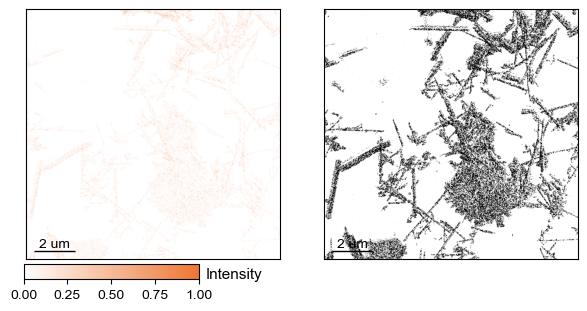

In [35]:
# element mappings 图
%matplotlib inline
ps_mappings_Mn_bool = np.where(ps_mappings_Mn.data, 0, 1)

plt.close('all')
fig = plt.figure(figsize=(7, 2.5))
gs = gridspec.GridSpec(1, 2, width_ratios=None, height_ratios=None, wspace=0, hspace=0, figure=fig)

# 图 A
subfig = fig.add_subfigure(gs[0, 0], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0, 0, 1.0, 1.0])
im = ax.imshow(ps_mappings_Mn.data/ps_mappings_Mn.data.max(), cmap=transparent_single_color_cmap(colors[0]), aspect=1.0)
add_sizebar(ax, 2, ps_mappings_Mn, 'k')
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False,)

cax = subfig.add_subplot()
cax.set_position([0.13, -0.08, 0.5, 0.06])
subfig.colorbar(mappable=im, cax=cax, ticks=np.linspace(0, 1, 5), format='{x:.2f}', location='bottom', orientation='horizontal')
cax.tick_params(axis='x', direction='out')
cax.text(1.04, 0.35, r'Intensity', horizontalalignment='left', verticalalignment='center', transform=cax.transAxes, fontsize=11, c='k')

# 图 B
subfig = fig.add_subfigure(gs[0, 1], zorder=0)
ax = subfig.add_subplot()
ax.set_position([-0.15, 0, 1.0, 1.0])
im = ax.imshow(ps_mappings_Mn_bool, cmap='gray', aspect=1.0)
add_sizebar(ax, 2, ps_mappings_Mn, 'k')
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False,)

plt.savefig(path.joinpath(path_out, r'3_300_sTXM_mapping.tif'), pad_inches=0.0, bbox_inches='tight', dpi=300, transparent=False, pil_kwargs={"compression": "tiff_lzw"})
plt.savefig(path.joinpath(path_out, r'3_600_sTXM_mapping.tif'), pad_inches=0.0, bbox_inches='tight', dpi=600, transparent=False, pil_kwargs={"compression": "tiff_lzw"})
plt.show()

### Cluster analysis

In [36]:
crop_size_a, crop_size_b, crop_size_c, crop_size_d = 50, 550, 400, 900

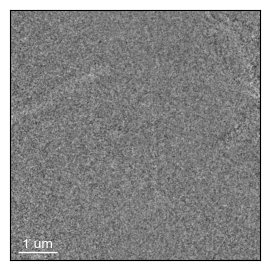

In [37]:
# The figure croped
%matplotlib inline
plt.close('all')
fig = plt.figure(figsize=(3.3, 2.5))
gs = gridspec.GridSpec(1, 1, width_ratios=None, height_ratios=None, wspace=0, hspace=0, figure=fig)

subfig = fig.add_subfigure(gs[0, 0], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0, 0, 1.0, 1.0])
ax.imshow(ps_Mn_L.sum(-1).inav[crop_size_a:crop_size_b,crop_size_c:crop_size_d].data, cmap='gray')
add_sizebar(ax, 1, ps_Mn_L.sum(-1), 'w')
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False,)

plt.savefig(path.joinpath(path_out, f'4_300_sTXM_clusters_{crop_size_a}_{crop_size_b}_{crop_size_c}_{crop_size_d}_HADDF.tif'), pad_inches=0.0, bbox_inches='tight', dpi=300, transparent=False, pil_kwargs={"compression": "tiff_lzw"})
plt.savefig(path.joinpath(path_out, f'4_600_sTXM_clusters_{crop_size_a}_{crop_size_b}_{crop_size_c}_{crop_size_d}_HADDF.tif'), pad_inches=0.0, bbox_inches='tight', dpi=600, transparent=False, pil_kwargs={"compression": "tiff_lzw"})
plt.show()

In [38]:
%%time
# cluster 分析
s = ps_Mn_L.inav[crop_size_a:crop_size_b,crop_size_c:crop_size_d].deepcopy()
clusters_mask = mask_mapping_empty.inav[crop_size_a:crop_size_b,crop_size_c:crop_size_d].deepcopy()
s.decomposition(algorithm="SVD", reproject='signal', navigation_mask=clusters_mask)   # centre="navigation"  centre="signal"
# num_clusters = s.estimate_number_of_clusters(cluster_source="decomposition", preprocessing="norm", algorithm="kmeans", navigation_mask=clusters_mask.data)
# s.plot_cluster_metric()
# display(num_clusters)
num_clusters = 3
s.cluster_analysis(cluster_source="decomposition", n_clusters=num_clusters, preprocessing="norm", algorithm="kmeans", n_init=8, navigation_mask=clusters_mask.data)

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=None
  centre=None
CPU times: total: 4min 33s
Wall time: 14.3 s


In [39]:
cluster_signals = s.get_cluster_signals(signal='mean')
cluster_labels = s.get_cluster_labels()
display(num_clusters)

3

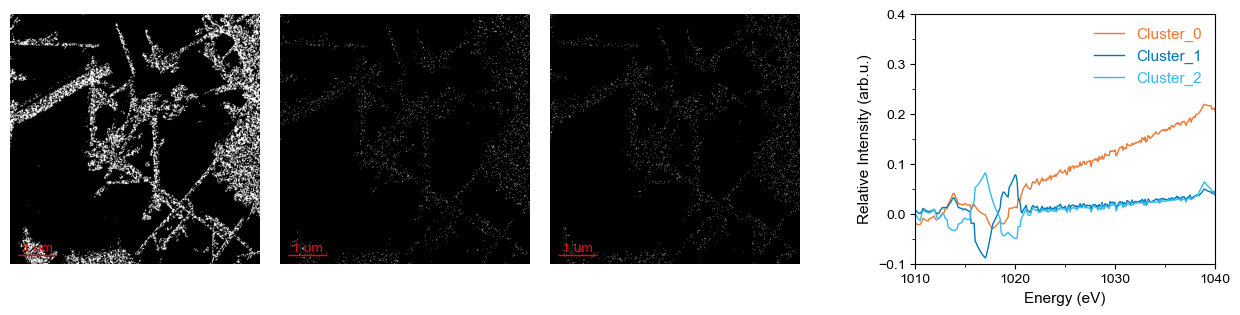

In [40]:
# cluster 分布
%matplotlib inline
plt.close('all')
fig = plt.figure(figsize=((cluster_signals.data.shape[0]+1)*3.0, 2.5))
gs = gridspec.GridSpec(1, (cluster_signals.data.shape[0]+1), width_ratios=np.ones((cluster_signals.data.shape[0]+1)), height_ratios=None,
                        wspace=0.1, hspace=0, figure=fig)
for i in range(cluster_signals.data.shape[0]):
    subfig = fig.add_subfigure(gs[0, i], zorder=0)
    ax = subfig.add_subplot()
    ax.set_position([-0.1*i, 0, 1.0, 1.0])
    ax.imshow(cluster_labels.inav[i].data, cmap='gray')
    add_sizebar(ax, 1, cluster_labels, 'r')
    ax.set_axis_off()
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False,)
    
# 图，倒数第二张
subfigc = fig.add_subfigure(gs[0, -1], zorder=0)
ax = subfigc.add_subplot()
ax.set_position([0.1, 0, 1.0, 1.0])

for i in range(cluster_signals.data.shape[0]):
    ax.plot(cluster_signals.axes_manager['Energy'].axis, cluster_signals.inav[i].data, c=colors[i], ls='-',lw=1.0, label=f'Cluster_{i}', zorder=i)
    
ax.legend(loc='upper left', bbox_to_anchor=(0.55, 1.0), ncols=1, frameon=False, fontsize=11, labelcolor='linecolor', columnspacing=0.4)
ax.set_ylabel(r'Relative Intensity (arb.u.)', fontsize=11)
ax.set_xlabel(r'Energy (eV)', fontsize=11)
ax.set_xlim(1010.0, 1040.0)
ax.set_ylim(-0.1, 0.4)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1, offset=0))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.05, offset=0))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10, offset=0))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=5, offset=0))

plt.savefig(path.joinpath(path_out, f'4_300_sTXM_clusters_labels_{num_clusters}.tif'), pad_inches=0.0, bbox_inches='tight', dpi=300, transparent=False, pil_kwargs={"compression": "tiff_lzw"})
plt.savefig(path.joinpath(path_out, f'4_600_sTXM_clusters_labels_{num_clusters}.tif'), pad_inches=0.0, bbox_inches='tight', dpi=600, transparent=False, pil_kwargs={"compression": "tiff_lzw"})
plt.show()

In [41]:
if num_clusters == 2:
    pd.DataFrame([cluster_signals.inav[0].axes_manager[0].axis, cluster_signals.inav[0].data, cluster_signals.inav[1].axes_manager[0].axis, cluster_signals.inav[1].data]).T.to_csv(path.joinpath(path_out, f'4_cluster_signals_{num_clusters}.csv'), sep=',', header=[r'Energy', r'1#', r'Energy', r'2#'], index=None)
if num_clusters == 3:  
    pd.DataFrame([cluster_signals.inav[0].axes_manager[0].axis, cluster_signals.inav[0].data, cluster_signals.inav[1].axes_manager[0].axis, cluster_signals.inav[1].data, cluster_signals.inav[2].axes_manager[0].axis, cluster_signals.inav[2].data,]).T.to_csv(path.joinpath(path_out, f'4_cluster_signals_{num_clusters}.csv'), sep=',', header=[r'Energy', r'1#', r'Energy', r'2#', r'Energy', r'3#',], index=None)

In [42]:
cluster_signals.save(path.joinpath(path_out, f'4_cluster_signals_{num_clusters}.hspy'), overwrite=True)
cluster_labels.save(path.joinpath(path_out, f'4_cluster_labels_{num_clusters}.hspy'), overwrite=True)

### 选择性区域

In [ ]:
# %matplotlib ipympl
# ps_recon_c.plot()
# line_roi = hs.roi.Line2DROI(8.40, 5.26, 8.04, 5.26)
# roi1D = line_roi.interactive(ps_recon_c, color="yellow")
# rectangular_roi = hs.roi.RectangularROI(left=line_roi.x1-0.4, right=line_roi.x2+0.6, top=line_roi.y1-0.2, bottom=line_roi.y2+0.1)
# roi2D = rectangular_roi(ps_recon_c)

In [ ]:
# line_roi.trait_get()
# # rectangular_roi

In [ ]:
# %matplotlib inline

# plt.close('all')
# fig = plt.figure(figsize=(10.0, 5.5))
# gs = gridspec.GridSpec(2, 3, width_ratios=[1,1,1], height_ratios=[1,1],
#                         wspace=0, hspace=0, figure=fig)
# # 图 A # 定义 Zn mapping 的颜色
# mapping_s = mpl.colors.LinearSegmentedColormap.from_list(name=r'mapping_s', colors=['w', 'k'], N=2)
# subfiga = fig.add_subfigure(gs[0, 0], zorder=0)
# ax = subfiga.add_subplot()
# ax.set_position([0, 0, 0.8, 0.8])
# ax.imshow(ps_recon_c.sum(-1).data, cmap=mapping_s)
# add_sizebar(ax, 1.0, 'w')
# remove_spine(ax)
# ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False,)

# rect1 = mpl.patches.Rectangle((int(rectangular_roi.x/ps_recon_c.axes_manager[0].scale), int(rectangular_roi.y/ps_recon_c.axes_manager[1].scale)), int(rectangular_roi.width/ps_recon_c.axes_manager[0].scale), int(rectangular_roi.height/ps_recon_c.axes_manager[1].scale), linewidth=1, edgecolor='y', facecolor='none', transform=ax.transData, zorder=5)
# ax.add_patch(rect1)

# # 图 B
# subfigb = fig.add_subfigure(gs[0, 1], zorder=0)
# ax = subfigb.add_subplot()
# ax.set_position([-0.2, 0, 0.8, 0.8])
# ax.imshow(roi2D.sum(-1).data, cmap='gray')
# add_sizebar(ax, 0.2, 'r')
# remove_spine(ax)
# ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False,)

# # 图 D
# subfigd = fig.add_subfigure(gs[1, 0], zorder=0)
# ax = subfigd.add_subplot()
# ax.set_position([0.0, 0.0, 0.8, 0.8])

# im = ax.imshow(roi2D.mean(axis='y_position').data[~np.isnan(roi2D.mean(axis='y_position').data).any(axis=1)], aspect=0.8, cmap='gray',
#               extent=[index(energy, 635.0), index(energy, 665.0), 0, roi2D.mean(axis='y_position').data[~np.isnan(roi2D.mean(axis='y_position').data).any(axis=1)].shape[1]])
# ax.set_ylabel(r'Intensity (count)', fontsize=11)
# ax.set_xlabel(r'Energy (eV)', fontsize=11)
# ax.set_xticks(ticks=np.arange(index(energy, 635.0), index(energy, 665.0)), labels=energy[index(energy, 635.0):index(energy, 665.0)].round(1))
# ax.xaxis.set_major_locator(ticker.MultipleLocator(base=40, offset=0))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=20, offset=0))

# ax.tick_params(axis='y', which='both', left=False, labelleft=False,)

# cax = subfigd.add_subplot()
# cax.set_position([0.78, 0.1, 0.06, 0.6])
# subfigd.colorbar(mappable=im, cax=cax, ticks=[])

# cax.text(0.0, 1.11, r'High', horizontalalignment='left',
#         verticalalignment='top', transform=cax.transAxes, fontsize=9, c='k')
# cax.text(0.0, -0.05, r'Low', horizontalalignment='left',
#         verticalalignment='top', transform=cax.transAxes, fontsize=9, c='k')
# # 图 E
# subfige = fig.add_subfigure(gs[1, 1], zorder=0)
# ax = subfige.add_subplot()
# ax.set_position([0.05, 0, 0.8, 0.8])
# color_A = mpl.colormaps['coolwarm'](np.linspace(0, 1, roi2D.mean(axis='y_position').data.shape[0]//2))

# for i in range(roi2D.mean(axis='y_position').data.shape[0]//2):
#     ax.plot(energy, roi2D.mean(axis='y_position').data[i, :], c=color_A[i], alpha=1 - 0.02*i, zorder=i)

# ax.set_ylabel(r'Intensity (count)', fontsize=11)
# ax.set_xlabel(r'Energy (eV)', fontsize=11)
# ax.set_xlim(635.0, 665.0)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10, offset=-5))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=5, offset=0))

# plt.savefig(path.joinpath(path_out, r'12_sTXM_Seclected_Bulk_Surface_1.tif'), 
#             pad_inches=0.05, bbox_inches='tight', dpi=300, transparent=False)
# plt.show()

In [ ]:
# %matplotlib inline

# plt.close('all')
# fig = plt.figure(figsize=(10.0, 5.5))
# gs = gridspec.GridSpec(2, 3, width_ratios=[1,1,1], height_ratios=[1,1],
#                         wspace=0, hspace=0, figure=fig)
# # 图 A
# subfiga = fig.add_subfigure(gs[0, 0], zorder=0)
# ax = subfiga.add_subplot()
# ax.set_position([0, 0, 0.8, 0.8])
# ax.imshow(roi2D.sum(-1).data, cmap='gray')
# add_sizebar(ax, 0.2, 'r')
# remove_spine(ax)
# ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False,)

# # 图 B
# subfigb = fig.add_subfigure(gs[0, 1], zorder=0)
# ax = subfigb.add_subplot()
# ax.set_position([-0.40, 0, 0.8, 0.8])

# im = ax.imshow(roi1D.data[~np.isnan(roi1D.data).any(axis=1)], aspect=0.8, cmap='gray', # 0.55
#                extent=[index(energy, 635.0), index(energy, 665.0), 0, roi1D.data[~np.isnan(roi1D.data).any(axis=1)].shape[1]])
# ax.set_ylabel(r'Intensity (count)', fontsize=11)
# ax.set_xlabel(r'Energy (eV)', fontsize=11)
# ax.set_xticks(ticks=np.arange(index(energy, 635.0), index(energy, 665.0)), labels=energy[index(energy, 635.0):index(energy, 665.0)].round(1))
# ax.xaxis.set_major_locator(ticker.MultipleLocator(base=40, offset=0))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=20, offset=0))

# ax.tick_params(axis='y', which='both', left=False, labelleft=False,)

# cax = subfigb.add_subplot()
# cax.set_position([0.40, 0.1, 0.06, 0.6])
# subfigb.colorbar(mappable=im, cax=cax, ticks=[])

# cax.text(0.0, 1.11, r'High', horizontalalignment='left',
#         verticalalignment='top', transform=cax.transAxes, fontsize=9, c='k')
# cax.text(0.0, -0.05, r'Low', horizontalalignment='left',
#         verticalalignment='top', transform=cax.transAxes, fontsize=9, c='k')
# # 图 C
# subfigc = fig.add_subfigure(gs[0, 2], zorder=0)
# ax = subfigc.add_subplot()
# ax.set_position([-0.30, 0, 0.8, 0.8])
# color_A = mpl.colormaps['coolwarm'](np.linspace(0, 1, roi1D.data.shape[0]//2))

# for i in range(roi1D.data.shape[0]//2):
#     ax.plot(energy, roi1D.data[i, :], c=color_A[i], alpha=1 - 0.02*i, zorder=i)

# ax.set_ylabel(r'Intensity (count)', fontsize=11)
# ax.set_xlabel(r'Energy (eV)', fontsize=11)
# ax.set_xlim(635.0, 665.0)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10, offset=0))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=5, offset=0))

# # 图 D
# subfigd = fig.add_subfigure(gs[1, 1], zorder=0)
# ax = subfigd.add_subplot()
# ax.set_position([-0.40, 0.0, 0.8, 0.8])

# im = ax.imshow(roi2D.mean(axis='y_position').data[~np.isnan(roi2D.mean(axis='y_position').data).any(axis=1)], aspect=0.8, cmap='gray',
#               extent=[index(energy, 635.0), index(energy, 665.0), 0, roi2D.mean(axis='y_position').data[~np.isnan(roi2D.mean(axis='y_position').data).any(axis=1)].shape[1]])
# ax.set_ylabel(r'Intensity (count)', fontsize=11)
# ax.set_xlabel(r'Energy (eV)', fontsize=11)
# ax.set_xticks(ticks=np.arange(index(energy, 635.0), index(energy, 665.0)), labels=energy[index(energy, 635.0):index(energy, 665.0)].round(1))
# ax.xaxis.set_major_locator(ticker.MultipleLocator(base=40, offset=0))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=20, offset=0))

# ax.tick_params(axis='y', which='both', left=False, labelleft=False,)

# cax = subfigd.add_subplot()
# cax.set_position([0.4, 0.1, 0.06, 0.6])
# subfigd.colorbar(mappable=im, cax=cax, ticks=[])

# cax.text(0.0, 1.11, r'High', horizontalalignment='left',
#         verticalalignment='top', transform=cax.transAxes, fontsize=9, c='k')
# cax.text(0.0, -0.05, r'Low', horizontalalignment='left',
#         verticalalignment='top', transform=cax.transAxes, fontsize=9, c='k')
# # 图 E
# subfige = fig.add_subfigure(gs[1, 2], zorder=0)
# ax = subfige.add_subplot()
# ax.set_position([-0.30, 0, 0.8, 0.8])
# color_A = mpl.colormaps['coolwarm'](np.linspace(0, 1, roi2D.mean(axis='y_position').data.shape[0]//2))

# for i in range(roi2D.mean(axis='y_position').data.shape[0]//2):
#     ax.plot(energy, roi2D.mean(axis='y_position').data[i, :], c=color_A[i], alpha=1 - 0.02*i, zorder=i)

# ax.set_ylabel(r'Intensity (count)', fontsize=11)
# ax.set_xlabel(r'Energy (eV)', fontsize=11)
# ax.set_xlim(635.0, 665.0)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10, offset=-5))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=5, offset=0))

# plt.savefig(path.joinpath(path_out, r'12_sTXM_Seclected_Bulk_Surface.tif'), 
#             pad_inches=0.05, bbox_inches='tight', dpi=300, transparent=False)
# plt.show()